In [1]:
import numpy as np
import pandas as pd
import pylab as plt

from tabulate import tabulate
import seaborn as sns
import pickle

import warnings

warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA

from prophet import Prophet
from prophet import diagnostics
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

## Load Data

In [4]:
cons_df = pd.read_csv('./../../datasets/conso-inf36-region.csv', sep=';')
weather_df = pd.read_csv('./../../datasets/donnees-synop-essentielles-omm.csv', sep=';')

In [5]:
cons_df.drop(['Région', 'Code région', 'Plage de puissance souscrite', 'Nb points soutirage', 'Total énergie soutirée (Wh)',
              'Courbe Moyenne n°1 (Wh)', 'Indice représentativité Courbe n°1 (%)', 'Courbe Moyenne n°2 (Wh)',
              'Indice représentativité Courbe n°2 (%)', 'Indice représentativité Courbe n°1 + n°2 (%)',
              'Jour max du mois (0/1)', 'Semaine max du mois (0/1)'], axis='columns', inplace=True)
cons_df.dropna(inplace=True)
cons_df['Horodate'] = pd.to_datetime(cons_df['Horodate'].values, utc=True)
cons_df['Horodate'] = cons_df['Horodate'].dt.tz_localize(None)
cons_df = cons_df[cons_df['Profil'].str.contains("ENT")]
cons_df = cons_df.groupby('Horodate').sum().iloc[::-1]
cons_df.head(100)

,Courbe Moyenne n°1 + n°2 (Wh)
Horodate,
2021-12-31 22:30:00,1808.0
2021-12-31 22:00:00,1808.0
2021-12-31 21:30:00,1808.0
2021-12-31 21:00:00,1808.0
2021-12-31 20:30:00,1808.0
...,...
2021-12-29 23:00:00,1777.0
2021-12-29 22:30:00,1808.0
2021-12-29 22:00:00,1808.0


In [6]:
weather_df.drop(['ID OMM station', 'Type de tendance barométrique', 'Temps présent', 'Temps passé 1', 'Temps passé 2', 'Nebulosité totale', 'Type des nuages de l\'étage inférieur', 'Type des nuages de l\'étage moyen', 'Type des nuages de l\'étage supérieur', 'Niveau barométrique', 'Géopotentiel', 'Température minimale sur 12 heures', 'Température minimale sur 24 heures', 'Température maximale sur 12 heures', 'Température maximale sur 24 heures', 'Méthode de mesure Température du thermomètre mouillé', 'Température du thermomètre mouillé', 'Hauteur de la neige fraîche', 'Hauteur totale de la couche de neige, glace, autre au sol', 'Periode de mesure de la neige fraiche', 'Periode de mesure de la rafale', 'Phénomène spécial 1', 'Phénomène spécial 2', 'Phénomène spécial 3', 'Phénomène spécial 4', 'Coordonnees', 'Nom', 'Type de tendance barométrique.1', 'Temps passé 1.1', 'Temps présent.1', 'Température minimale sur 12 heures (°C)', 'Température minimale sur 24 heures (°C)', 'Température maximale sur 12 heures (°C)', 'Température maximale sur 24 heures (°C)', 'Latitude', 'Longitude', 'Altitude', 'communes (name)', 'communes (code)', 'EPCI (name)', 'EPCI (code)', 'department (name)', 'department (code)', 'region (name)', 'region (code)', 'Hauteur de la base des nuages de l\'étage inférieur', 'Nébulosité couche nuageuse 1', 'Nébulosité couche nuageuse 2', 'Nébulosité couche nuageuse 3', 'Nébulosité couche nuageuse 4', 'Type nuage 1', 'Type nuage 2', 'Type nuage 3', 'Type nuage 4', 'Hauteur de base 1', 'Hauteur de base 2', 'Hauteur de base 3', 'Hauteur de base 4', 'Etat du sol'], axis='columns', inplace=True)

weather_df['Date'] = pd.to_datetime(weather_df['Date'].values, utc=True)
weather_df['Date'] = weather_df['Date'].dt.tz_localize(None)
weather_df.set_index('Date', inplace=True)
weather_df.head(100)

,Pression au niveau mer,Variation de pression en 3 heures,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,Visibilité horizontale,Nébulosité des nuages de l' étage inférieur,Pression station,...,Rafale sur les 10 dernières minutes,Rafales sur une période,Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Précipitations dans les 24 dernières heures,Température (°C),Température minimale du sol sur 12 heures (en °C),mois_de_l_annee
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-02 09:00:00,101660,10.0,70.0,2.0,295.85,288.15,62,16610.0,0.0,101100.0,...,4.2,4.5,0.0,0.0,0.0,0.0,14.8,22.7,17.9,6
2020-06-02 12:00:00,101550,-100.0,180.0,1.0,299.55,287.35,47,18830.0,2.0,101000.0,...,3.0,5.0,0.0,0.0,0.0,0.0,14.8,26.4,17.9,6
2020-06-09 12:00:00,101860,-20.0,270.0,4.5,290.75,287.45,81,4320.0,1.0,101290.0,...,6.4,8.1,3.7,3.7,3.7,3.7,5.3,17.6,12.6,6
2020-06-10 21:00:00,101500,-60.0,150.0,1.1,288.65,284.45,76,28410.0,7.0,100930.0,...,1.7,2.9,0.0,0.0,-0.1,-0.1,0.2,15.5,17.3,6
2020-05-26 00:00:00,102840,-10.0,30.0,3.5,290.85,284.15,65,31980.0,0.0,102270.0,...,4.5,4.5,0.0,0.0,0.0,0.0,0.0,17.7,16.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-18 09:00:00,102260,80.0,140.0,3.0,289.05,285.25,78,21060.0,0.0,101690.0,...,4.3,5.0,0.0,0.0,0.0,0.0,0.0,15.9,11.0,10
2021-10-12 18:00:00,102320,70.0,10.0,2.8,287.95,280.75,62,51060.0,0.0,101740.0,...,3.9,7.8,0.0,0.0,0.0,0.0,0.0,14.8,6.1,10
2021-10-06 15:00:00,102690,-40.0,290.0,0.7,292.65,283.35,55,47490.0,1.0,102120.0,...,1.7,4.5,0.0,0.0,0.0,0.0,0.4,19.5,9.3,10


In [7]:
table = []
for c in weather_df.columns:
    table.append([c, round((1 - len(weather_df[c].dropna()) / len(weather_df[c])) * 100, 4)])

print(tabulate(table, headers=['Feature', '% nan values']))

Feature                                              % nan values
-------------------------------------------------  --------------
Pression au niveau mer                                     0
Variation de pression en 3 heures                          0
Direction du vent moyen 10 mn                              0.0342
Vitesse du vent moyen 10 mn                                0.0342
Température                                                0
Point de rosée                                             0
Humidité                                                   0
Visibilité horizontale                                     0
Nébulosité  des nuages de l' étage inférieur               0.2567
Pression station                                           0
Variation de pression en 24 heures                         0.154
Température minimale du sol sur 12 heures                  1.8309
Rafale sur les 10 dernières minutes                        0.1882
Rafales sur une période                       

## PCA

In [8]:
# Get features and standardize them
feat = weather_df.dropna().values
feat_st = (feat - feat.mean()) / feat.std()

# Perform the PCA
pca = PCA(random_state=667).fit(feat_st)

# See how much of the variance is explained by the first n components
for i in range(pca.n_components_):
    exp_var = sum(pca.explained_variance_ratio_[:i+1])
    print('The first {0} components explain {1:.2%} of the variance in the data'.format(i+1, exp_var))
print('\n\n\n')

The first 1 components explain 99.47% of the variance in the data
The first 2 components explain 99.90% of the variance in the data
The first 3 components explain 99.99% of the variance in the data
The first 4 components explain 100.00% of the variance in the data
The first 5 components explain 100.00% of the variance in the data
The first 6 components explain 100.00% of the variance in the data
The first 7 components explain 100.00% of the variance in the data
The first 8 components explain 100.00% of the variance in the data
The first 9 components explain 100.00% of the variance in the data
The first 10 components explain 100.00% of the variance in the data
The first 11 components explain 100.00% of the variance in the data
The first 12 components explain 100.00% of the variance in the data
The first 13 components explain 100.00% of the variance in the data
The first 14 components explain 100.00% of the variance in the data
The first 15 components explain 100.00% of the variance in t

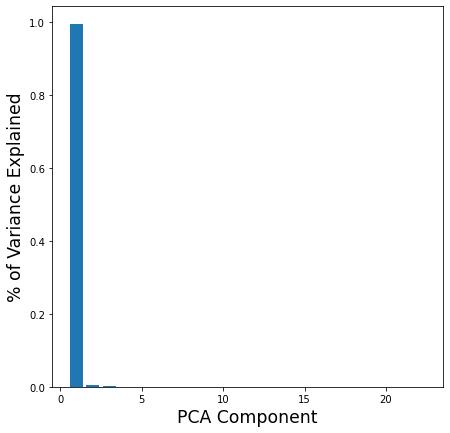

In [9]:
# Amount of variance explained bya single component and cumulative components
cmp_exp = pca.explained_variance_ratio_
cum_exp = [sum(cmp_exp[:i+1]) for i in range(len(cmp_exp))]

fig, ax = plt.subplots(figsize=(7, 7))
ax.bar(range(1, len(cmp_exp)+1), cmp_exp, color='C0')
ax.set_xlabel('PCA Component', fontsize='xx-large')
ax.set_ylabel('% of Variance Explained', fontsize='xx-large')
fig.show()

fig.savefig('pca_explained')

In [10]:
# Look at the weights of each feature for each component
weights = pd.DataFrame(pca.components_, columns=weather_df.columns, index =['PC' + str(n+1) for n in range(pca.n_components_)])
weights.columns = [col[6:] for col in weights.columns]
weights.head()

,on au niveau mer,ion de pression en 3 heures,ion du vent moyen 10 mn,e du vent moyen 10 mn,ature,de rosée,té,lité horizontale,sité des nuages de l' étage inférieur,on station,...,sur les 10 dernières minutes,s sur une période,itations dans la dernière heure,itations dans les 3 dernières heures,itations dans les 6 dernières heures,itations dans les 12 dernières heures,itations dans les 24 dernières heures,ature (°C),ature minimale du sol sur 12 heures (en °C),e_l_annee
PC1,-0.002864,-0.000063,0.000164,0.000013,0.000143,0.000025,-0.000545,0.999990,-0.000017,-0.002556,...,0.000019,0.000025,-0.000006,-1.269414e-05,-0.000019,-0.000024,-0.000036,0.000143,0.000073,-2.555146e-07
PC2,-0.693574,-0.012802,0.011249,0.000529,0.000807,0.001066,0.001384,-0.004242,0.000664,-0.687748,...,0.000801,0.000965,0.000144,4.080900e-04,0.000793,0.001459,0.002450,0.000807,0.001137,4.147235e-04
PC3,0.150790,-0.105668,-0.039385,0.000032,0.000399,-0.000518,-0.003773,-0.001439,-0.000649,0.150672,...,0.000057,-0.000034,0.000050,2.139002e-07,-0.000079,-0.000553,-0.002800,0.000399,-0.000808,-4.516255e-04
PC4,0.014542,0.715068,0.690684,0.001957,-0.000617,0.006024,0.023696,-0.000212,0.004064,0.014977,...,0.002488,0.003611,0.000312,8.585020e-04,0.002439,0.006643,0.009211,-0.000617,0.008139,-2.825414e-04
PC5,0.005233,0.690370,-0.721474,-0.001256,-0.009506,-0.007433,0.005595,0.000035,-0.004953,-0.015239,...,-0.002039,-0.001694,-0.000369,-6.834502e-04,-0.000332,0.000885,-0.000052,-0.009506,-0.005090,-3.031004e-04


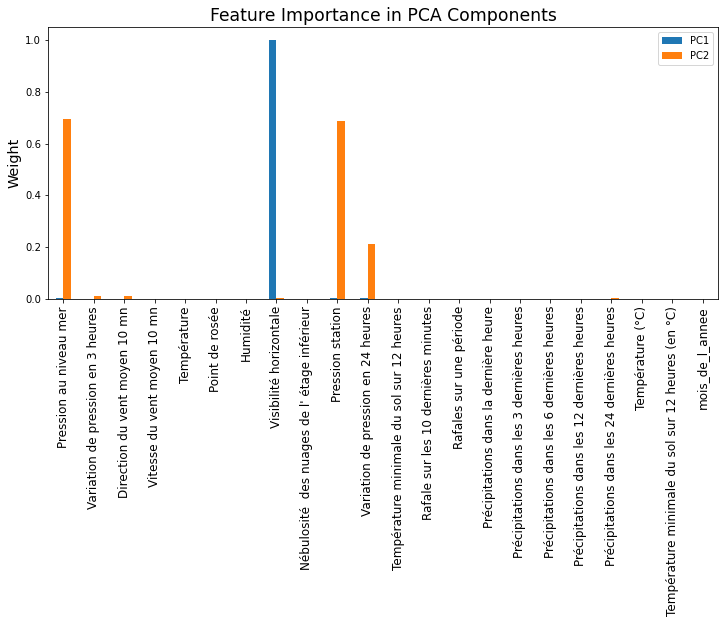

In [11]:
# plot the weights of the first compenents
fig, ax = plt.subplots(figsize=(12, 5))

abs(weights.iloc[:2, :].T).plot(kind='bar', ax=ax)
ax.set_title('Feature Importance in PCA Components', fontsize='xx-large')
ax.set_ylabel('Weight', fontsize='x-large')
ax.set_xticklabels(weather_df.columns.values.tolist(), rotation=90, fontsize='large')
ax.legend(loc='best')

fig.show();

In [12]:
data = cons_df[['Courbe Moyenne n°1 + n°2 (Wh)']].copy()

weather_df_clean = weather_df.dropna()
weather_pc = pd.DataFrame(data=pca.fit_transform(weather_df_clean)[:, :2],
                          index=weather_df_clean.index,
                          columns=['weather_pc', 'weather_pc2'])

data = cons_df[['Courbe Moyenne n°1 + n°2 (Wh)']].join(weather_pc).dropna().reset_index()
data = data.join(weather_df_clean['Visibilité horizontale'], on='Horodate')
data.head(1000)

,Horodate,Courbe Moyenne n°1 + n°2 (Wh),weather_pc,weather_pc2,Visibilité horizontale
0,2021-12-31 21:00:00,1808.0,-12523.191596,-1101.610355,12570.0
1,2021-12-31 18:00:00,1808.0,-9763.109031,-1103.110966,15330.0
2,2021-12-31 15:00:00,1808.0,10666.886154,-1154.587255,35760.0
3,2021-12-31 12:00:00,1808.0,-20782.955614,-1093.185779,4310.0
4,2021-12-31 09:00:00,1808.0,-21572.163611,-951.975967,3520.0
...,...,...,...,...,...
995,2021-08-26 15:00:00,1676.0,14843.366855,378.376433,39930.0
996,2021-08-26 12:00:00,1745.0,10662.763042,238.949746,35750.0
997,2021-08-26 09:00:00,1822.0,11872.759535,223.561801,36960.0
998,2021-08-26 06:00:00,1604.0,4313.222706,332.110642,29400.0


## Simple Prophet Model

### Acquire and clean data

In [13]:
# Rename columns to fit the Prophet format
data = data.rename(columns={'Horodate':'ds', 'Courbe Moyenne n°1 + n°2 (Wh)':'y', 'Visibilité horizontale':'visibility'})
#data.to_csv('data.csv')

# Standardize the data
colx = ['y', 'weather_pc', 'weather_pc2', 'visibility']

data_st = (data[colx] - data[colx].mean()) / data[colx].std()
data_st['ds'] = data['ds']
data_st['cap'] = data_st['y'].max()*1.2
data_st['floor'] = 0
#data_st.to_csv('data_st.csv')

In [14]:
data_st

,y,weather_pc,weather_pc2,visibility,ds,cap,floor
0,0.471596,-0.760320,-1.013539,-0.760020,2021-12-31 21:00:00,4.915918,0
1,0.471596,-0.592748,-1.014919,-0.592451,2021-12-31 18:00:00,4.915918,0
2,0.471596,0.647619,-1.062280,0.647929,2021-12-31 15:00:00,4.915918,0
3,0.471596,-1.261795,-1.005788,-1.261515,2021-12-31 12:00:00,4.915918,0
4,0.471596,-1.309711,-0.875867,-1.309478,2021-12-31 09:00:00,4.915918,0
...,...,...,...,...,...,...,...
5695,0.064592,-0.314818,-1.706220,-0.314382,2020-01-01 12:00:00,4.915918,0
5696,0.064592,-0.581388,-1.821734,-0.580915,2020-01-01 09:00:00,4.915918,0
5697,0.064592,-0.816314,-1.682550,-0.815877,2020-01-01 06:00:00,4.915918,0
5698,0.064592,-0.890369,-1.632585,-0.889947,2020-01-01 03:00:00,4.915918,0


### Train the model

In [15]:
# Create instance of model and train
prophet1 = Prophet(daily_seasonality=True,
                   weekly_seasonality=50,
                   yearly_seasonality=30,
                   seasonality_mode='additive',
                   changepoint_prior_scale=0.001,
                   growth="logistic")
prophet1.fit(data_st)

prophet1.stan_backend.logger = None
with open("prophet1.pickle", "wb") as f:
    pickle.dump(prophet1, f)

### Forecast future energy load

In [16]:
n_months = 24
n_days = n_months * 30
n_hours = (n_days * 24) // 3
print("We want to forecast:\n - {0} months, which is\n - {1} days, which is\n - {2} 3hours".format(n_months, n_days, n_hours))

# Create dataframe containing future energy load predictions
pred_period1 = prophet1.make_future_dataframe(periods=n_hours, freq="3H")
pred_period1['cap'] = data_st['y'].max()*1.2
pred_period1['floor'] = 0

preds1 = prophet1.predict(pred_period1)
#preds1.to_csv('preds1.csv')

We want to forecast:
 - 24 months, which is
 - 720 days, which is
 - 5760 3hours


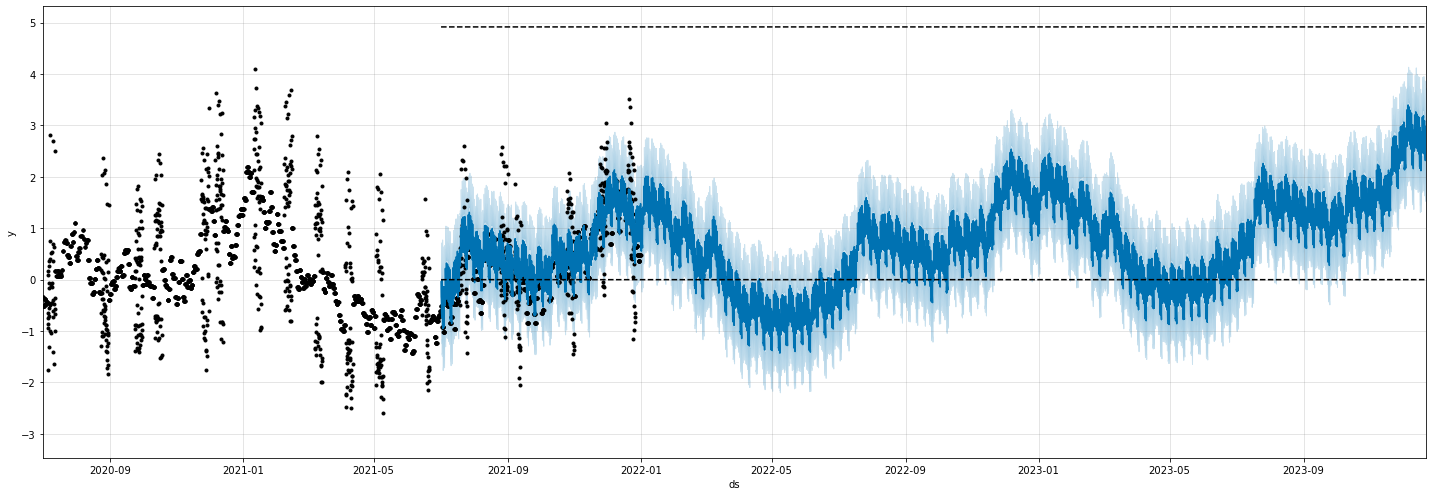

In [17]:
backtrack = (0.5 * 12 * 30 * 24) // 3
backtrack = int(backtrack)

fig = prophet1.plot(preds1[-backtrack - n_hours:], figsize=(20, 7))
plt.plot(data_st.ds[-backtrack:], data_st.y[-backtrack:], '--')
plt.xlim(data_st.ds.values[-backtrack], preds1.ds.values[-1] + np.timedelta64())
fig.show()

fig.savefig('prophet1_predictions.png')

In [18]:
def make_plot_block(preds, start, end, ax=None, xlabel='days'):

    # Truncate dataframes to only relevant portions
    actual = data_st.loc[(data_st.ds > start) & (data_st.ds < end), :].set_index('ds')
    forecast = preds.loc[(preds.ds > start) & (preds.ds < end), :].set_index('ds')

    actual.loc[:,'y'].plot(color='k', label='observations', ax=ax)
    forecast.loc[:,'yhat'].plot(color='steelblue', label='forecasts', ls='--', lw=3, ax=ax)
    ax.fill_between(forecast.index, forecast.loc[:,'yhat_lower'], forecast.loc[:,'yhat_upper'], color='steelblue', alpha=0.3)

    ax.grid(ls=':')
    ax.legend(fontsize=15)

    if xlabel == 'days':
        labels = [t.strftime('%b %d') for t in forecast.index]
    else:
        labels = [t.strftime("%b '") + t.strftime("%Y")[-2:] for t in forecast.index]
    ax.set_xticklabels(labels[::len(labels)//10], fontsize='large')

    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

    ax.set_ylabel('Energy Load', fontsize=15)
    ax.set_title(start + ' to ' + end, fontsize='xx-large')

def plot_seasons(preds, year):
    fig, ax = plt.subplots(4, 1, figsize=(20, 28))

    start = year + '-01-01'
    end = year + '-01-15'
    make_plot_block(preds, start, end, ax=ax[0], xlabel='days')

    start = year + '-04-01'
    end = year + '-04-15'
    make_plot_block(preds, start, end, ax=ax[1], xlabel='days')

    start = year + '-07-01'
    end = year + '-07-15'
    make_plot_block(preds, start, end, ax=ax[2], xlabel='days')

    start = year + '-10-01'
    end = year + '-10-15'
    make_plot_block(preds, start, end, ax=ax[3], xlabel='days')

    fig.subplots_adjust(hspace=0.35)
    return fig

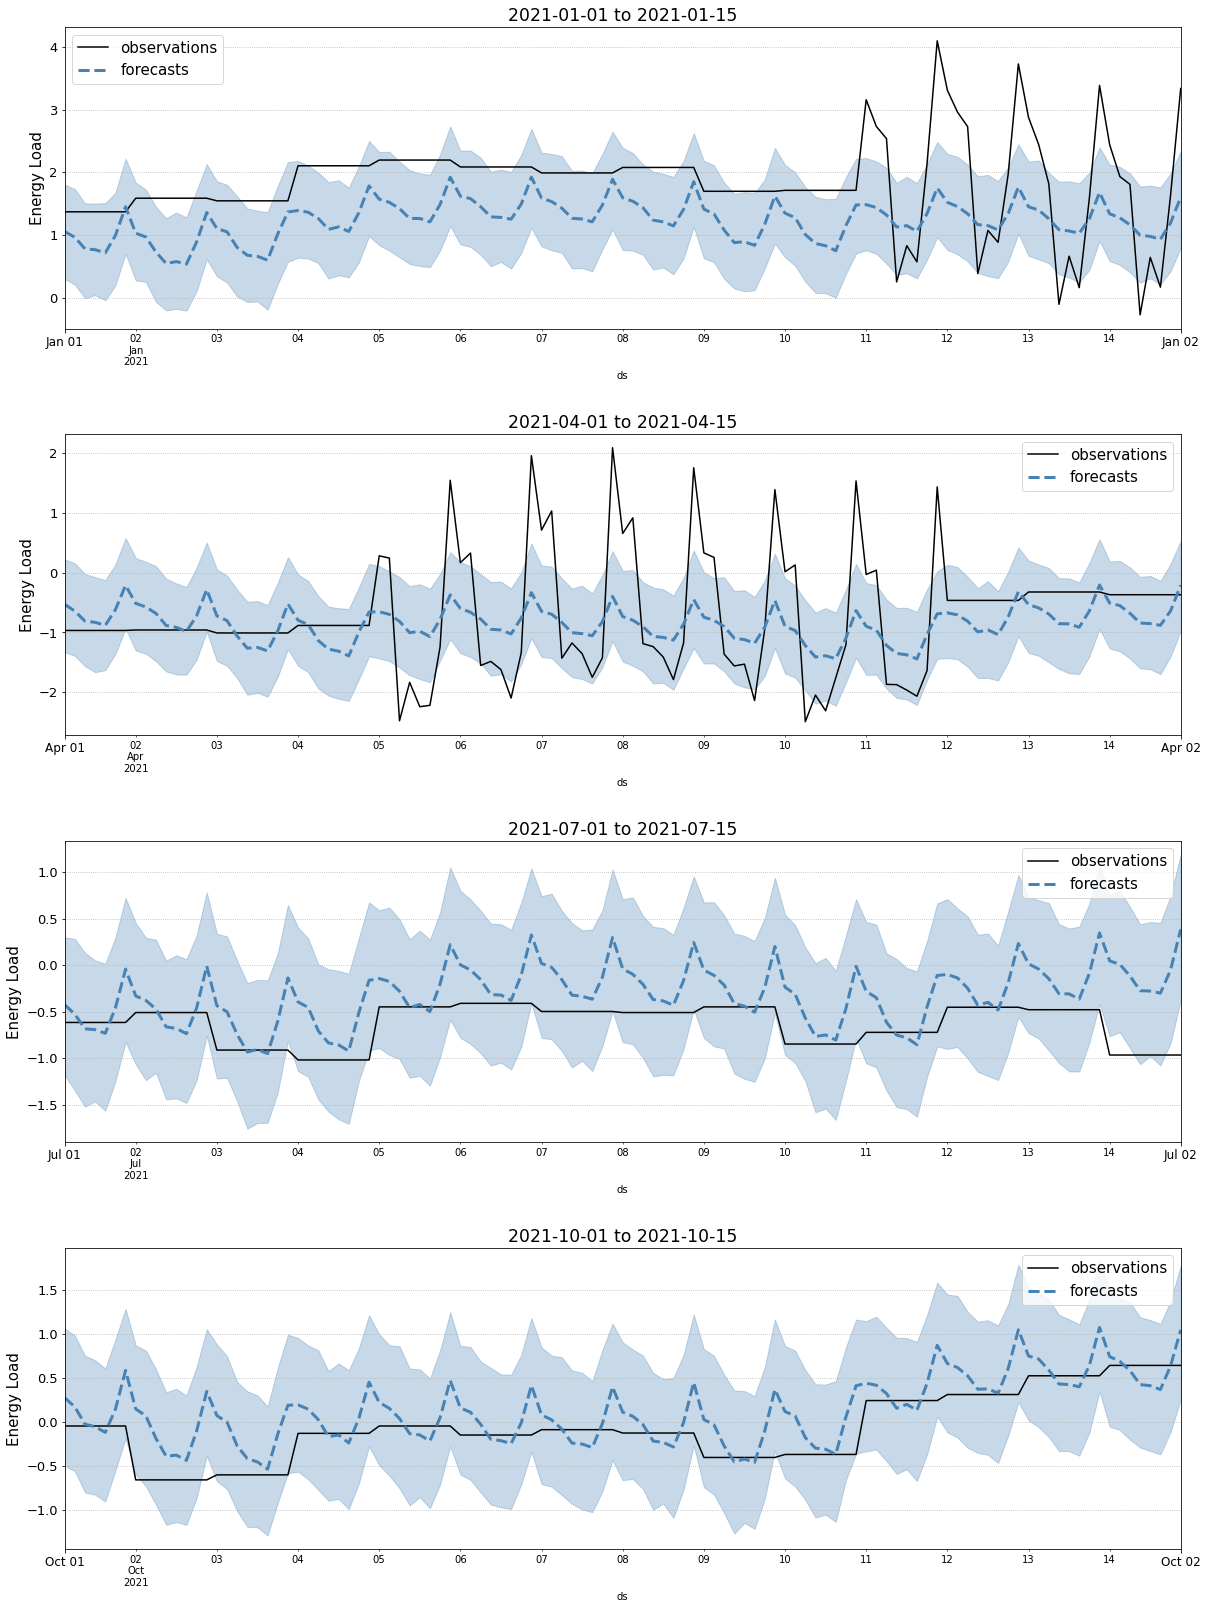

In [19]:
fig = plot_seasons(preds1, '2021')
fig.savefig('season_preds1.png')

### Examine the seasonality components of the model

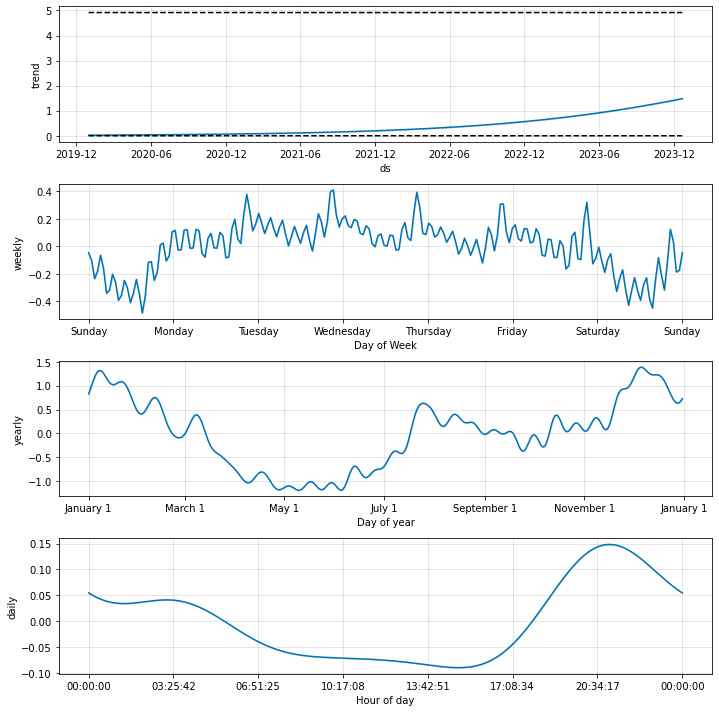

In [20]:
fig = prophet1.plot_components(preds1, figsize=(10, 10))
fig.savefig('prophet1_components.png')
fig.show()

### Model Validation

In [21]:
def mape(y_pred, y_true):
    ''' Mean average percent error statistic '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_pred - y_true) / np.abs(y_true))

def unstandardize(y):
    return y * data.y.std() + data.y.mean()

In [22]:
result1_cv = diagnostics.cross_validation(prophet1, horizon="90 days")
result1_cv.to_csv('result1_cv.csv')

# Unstandardize the results
result1_cv_adj = result1_cv.copy()
result1_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] *= data.y.std()
result1_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] += data.y.mean()
result1_cv_adj.to_csv('result1_cv_adj.csv')

INFO:prophet:Making 7 forecasts with cutoffs between 2021-01-05 21:00:00 and 2021-10-02 21:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
result1_day = result1_cv_adj.groupby(by=[result1_cv_adj.ds.dt.day,
                                         result1_cv_adj.ds.dt.month,
                                         result1_cv_adj.ds.dt.year]).sum()
result1_month = result1_cv_adj.groupby(by=[result1_cv_adj.ds.dt.month,
                                           result1_cv_adj.ds.dt.year]).sum()
result1_ag = result1_cv_adj.groupby('cutoff').sum()

print("Hourly mean average percent error: {:.2%}".format(mape(result1_cv_adj.yhat, result1_cv_adj.y)))
print("Daily mean average percent error: {:.2%}".format(mape(result1_day.yhat, result1_day.y)))
print("Monthly mean average percent error: {:.2%}".format(mape(result1_month.yhat, result1_month.y)))
print("3-month mean average percent error: {:.2%}".format(mape(result1_ag.yhat, result1_ag.y)))

Hourly mean average percent error: 8.97%
Daily mean average percent error: 6.73%
Monthly mean average percent error: 3.59%
3-month mean average percent error: 3.14%


In [24]:
 # Calculate the performance metrics on the cross-validation results
result1_p = performance_metrics(result1_cv_adj)
result1_p.to_csv('result1_p.csv')

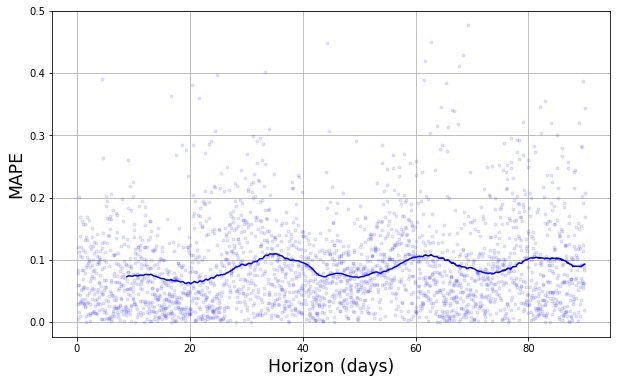

In [25]:
fig = plot_cross_validation_metric(result1_cv_adj[::2], metric='mape')
plt.xlabel('Horizon (days)', fontsize='xx-large')
plt.ylabel('MAPE', fontsize='xx-large')
fig.savefig('prophet1_horizon_mape.png')

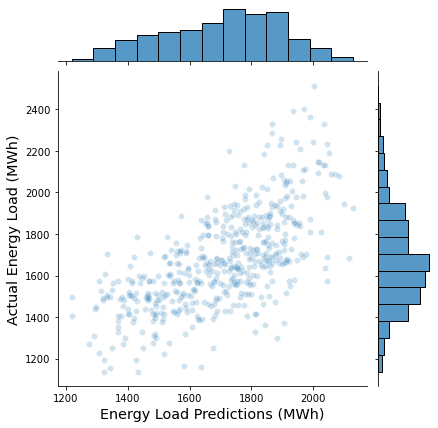

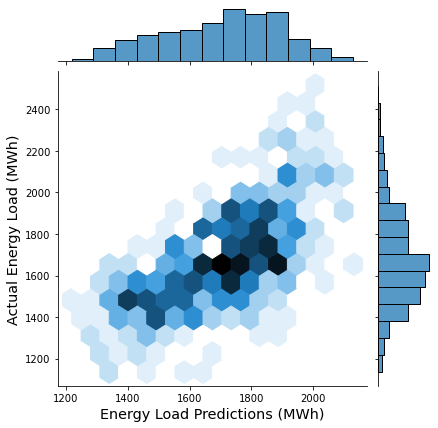

In [26]:
step = 10
grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], alpha=0.2)
grid.set_axis_labels('Energy Load Predictions (MWh)', 'Actual Energy Load (MWh)', fontsize='x-large')
grid.savefig('joint_scatter1.png')

grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], kind='hex')
grid.set_axis_labels('Energy Load Predictions (MWh)', 'Actual Energy Load (MWh)', fontsize='x-large')
grid.savefig('joint_hex1.png')

In [27]:
def plot_residuals(errs, fig=None, ax=None, display=True):
    if not fig:
        fig, ax = plt.subplots(figsize=(7, 7))
    sns.distplot(errs, bins=50, ax=ax)
    ax.set_title('Histogram of Prediction Residuals (Test Set)', fontsize='xx-large')
    plt.axvline(errs.median(), color='k', label='median')
    ax.set_xlabel('Error (MWh)', fontsize='xx-large')
    ax.set_yticks([])

    if display:
        ax.text(0.05, 0.9, "Median = {:+4.2f} MWh".
                format((errs).median()),
                fontsize=14, transform=ax.transAxes)
    return fig

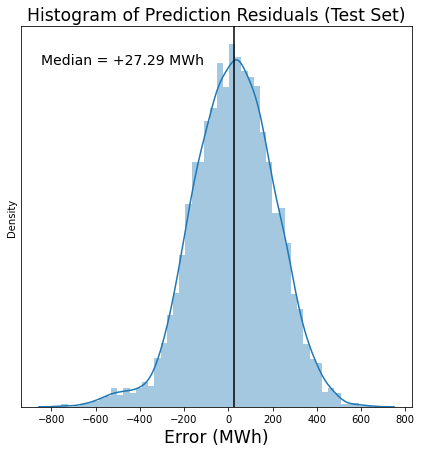

In [28]:
errs1 = result1_cv_adj.yhat - result1_cv_adj.y      # Units are now MWh, not standardized
fig = plot_residuals(errs1)
fig.savefig('residuals1_hist.png')
fig.show()

In [29]:
print('The median error was {0:.2%} of the mean energy demand.'.format(errs1.median() / result1_cv_adj.y.mean()))

The median error was 1.62% of the mean energy demand.


## More complex model

### Train the model

In [30]:
# Create base instance of Prophet
prophet2 = Prophet(seasonality_prior_scale=35,
                   weekly_seasonality=False,
                   seasonality_mode='additive',
                   changepoint_prior_scale=0.001,
                   growth="logistic")

# Add holidays
prophet2.add_country_holidays(country_name="FR")

# Add seasonalities
prophet2.add_seasonality(name='weekly', period=7, fourier_order=10)
prophet2.add_seasonality(name='quarterly', period=365/4, fourier_order=10)

# Add weather regressor
prophet2.add_regressor('weather_pc')
prophet2.add_regressor('visibility')

prophet2.fit(data_st)

prophet2.stan_backend.logger = None
with open("prophet2.pickle", "wb") as f:
    pickle.dump(prophet2, f)

### Forecast future energy load

In [31]:
n_months = 24
n_days = n_months * 30
n_hours = (n_days * 24) // 3
print("We want to forecast:\n - {0} months, which is\n - {1} days, which is\n - {2} 3hours".format(n_months, n_days, n_hours))

We want to forecast:
 - 24 months, which is
 - 720 days, which is
 - 5760 3hours


In [32]:
def fill_regressors(ds):
    '''
    This function takes in a datetime and returns the average `weather_pc` and
    'precipitation` (standardized) value for each observation in the historical
    dataset.

    The mean value is based on observations that occur in the same month, on the
    same day, and within +/- 2 hours of the input datetime. There are at most 5
    observations per year that fit this description.
    '''
    month = ds.month
    day = ds.day
    hour = ds.hour
    sub = data_st[(data_st.ds.dt.month == month) & (data_st.ds.dt.day == day) & (abs(data_st.ds.dt.hour - hour) < 2)]
    return sub[['weather_pc', 'visibility']].mean()

In [33]:
# Forecast the weather for the prediction period based on historical data

# Create dataframe containing each hour in the prediction period
pred_period2 = prophet2.make_future_dataframe(periods=n_hours, freq="3H")

pred_period2['cap'] = data_st['y'].max()*1.2
pred_period2['floor'] = 0

# Create empty columns for the `weather_pc` and `visibility` data
pred_period2['weather_pc'] = 0.
pred_period2['visibility'] = 0.

# Fill in the historical data for the `weather_pc` and `visibility` columns
pred_period2['weather_pc'][:-n_hours] = data_st.weather_pc
pred_period2['visibility'][:-n_hours] = data_st.visibility

# Forecast the weather and visibility for the prediction period
pred_weather_regressors = pred_period2.iloc[-n_hours:].ds.apply(fill_regressors)

# Add the forecasted data to the prediction period dataframe
pred_period2['weather_pc'][-n_hours:] = pred_weather_regressors.weather_pc
pred_period2['visibility'][-n_hours:] = pred_weather_regressors.visibility

# Save the prediction perdiod dataframe
pred_period2.to_csv('pred_period2.csv')

In [34]:
# Forecast the energy load over the prediction perdiod dataframe
pred_period2.dropna(inplace=True)
preds2 = prophet2.predict(pred_period2)  # will take 2 minutes

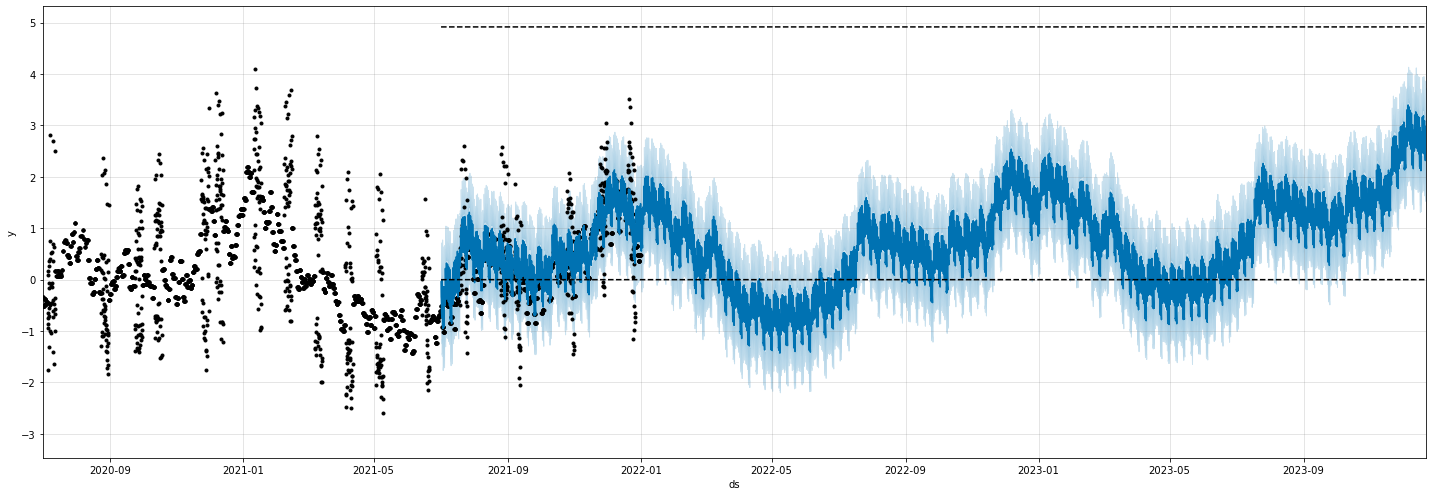

In [35]:
backtrack = (0.5 * 12 * 30 * 24) // 3
backtrack = int(backtrack)

fig = prophet2.plot(preds1[-backtrack - n_hours:], figsize=(20, 7))
plt.plot(data_st.ds[-backtrack:], data_st.y[-backtrack:], '--')
plt.xlim(data_st.ds.values[-backtrack], preds1.ds.values[-1] + np.timedelta64())
fig.show()

fig.savefig('prophet2_predictions.png')

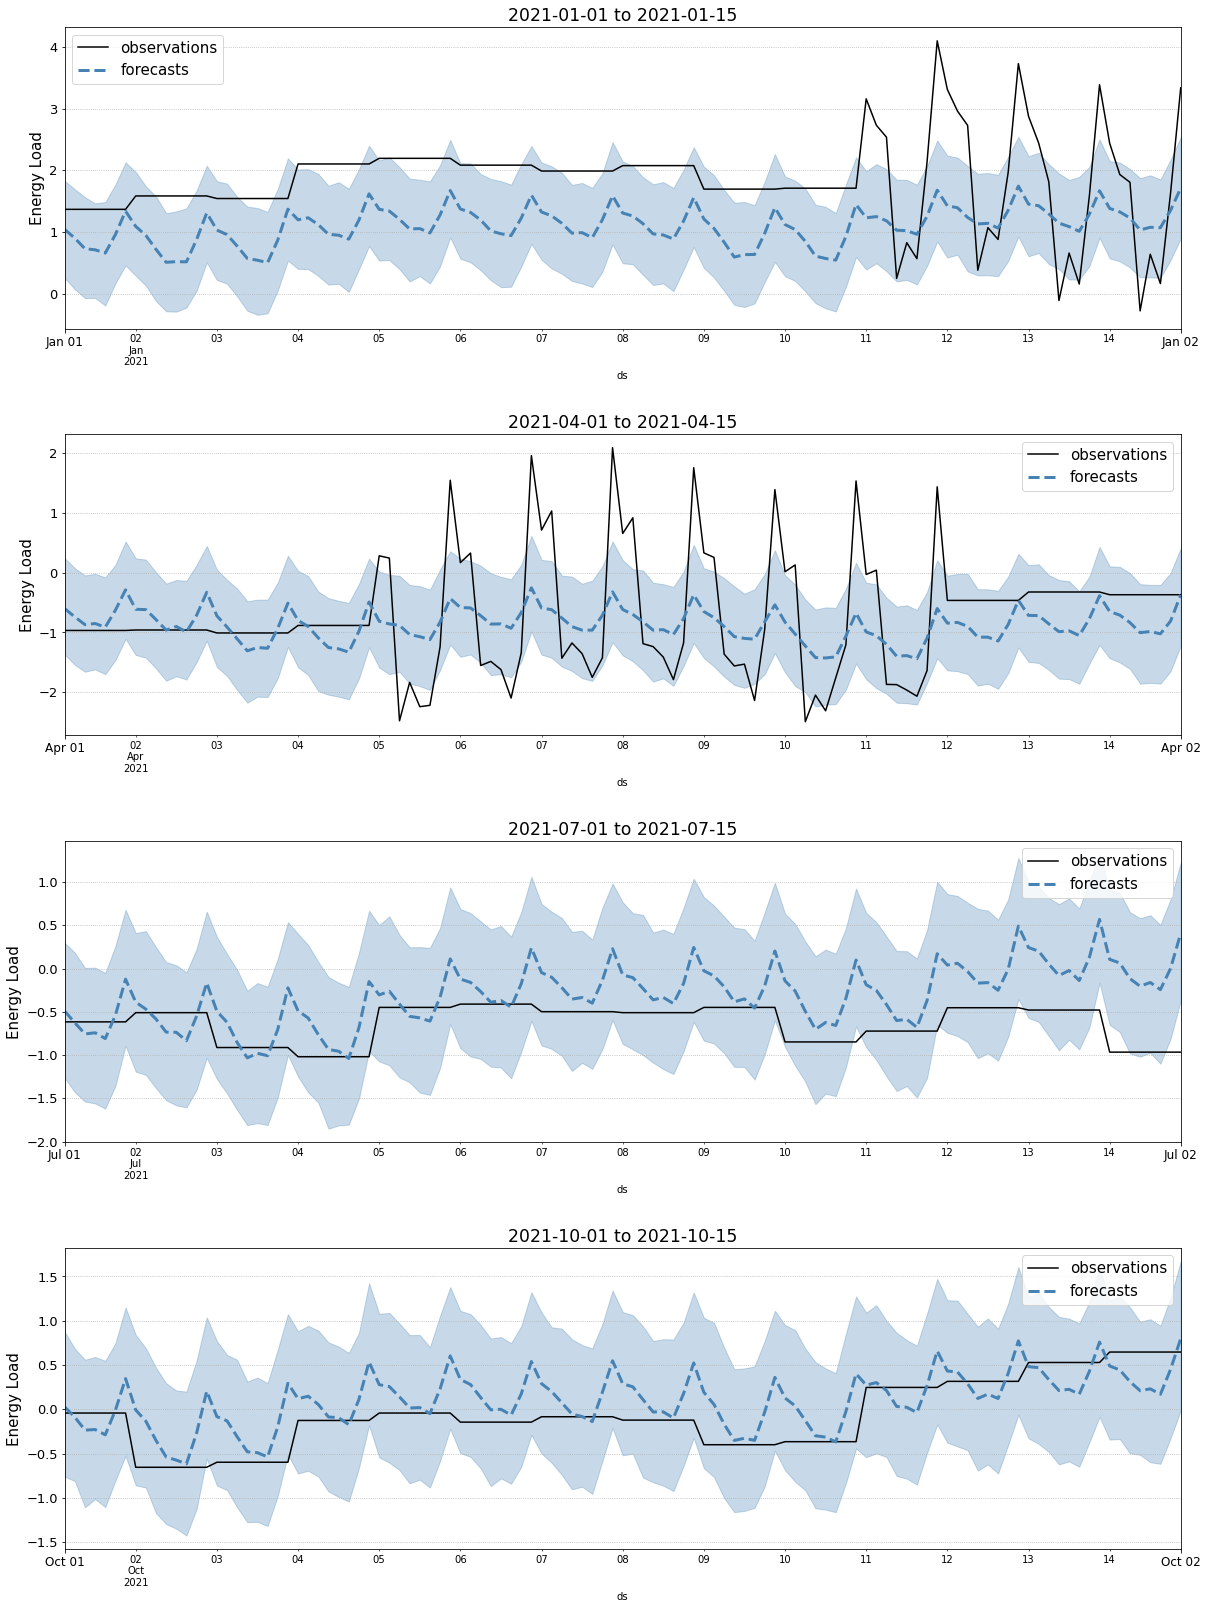

In [36]:
fig = plot_seasons(preds2, '2021')
fig.savefig('season_preds2.png')

### Examine the seasonality components of the model

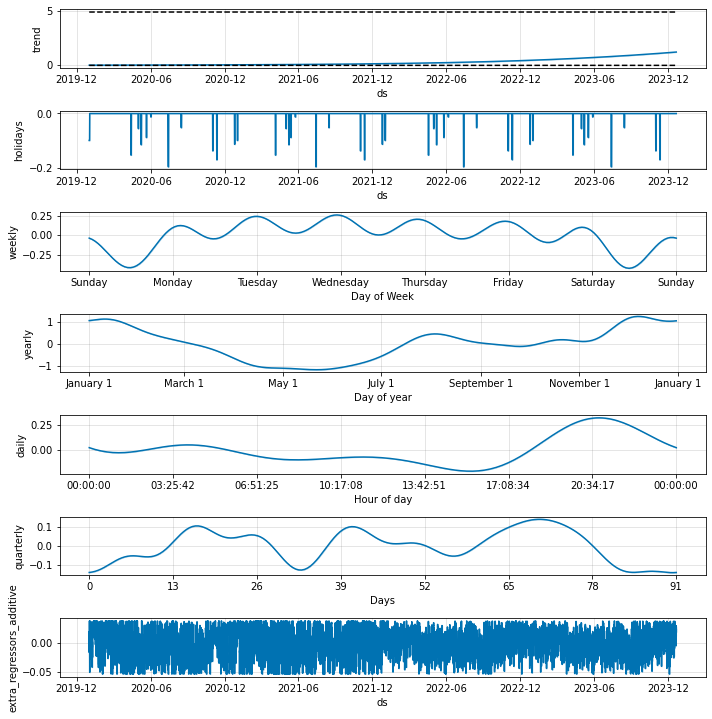

In [37]:
fig = prophet2.plot_components(preds2, figsize=(10, 10))
fig.savefig('prophet2_components.png')
fig.show()

### Model Validation

In [38]:
result2_cv = diagnostics.cross_validation(prophet2, horizon="90 days")
result2_cv.to_csv('result2_cv.csv')

# Unstandardize the results
result2_cv_adj = result2_cv.copy()
result2_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] *= data.y.std()
result2_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] += data.y.mean()
result2_cv_adj.to_csv('result2_cv_adj.csv')

INFO:prophet:Making 7 forecasts with cutoffs between 2021-01-05 21:00:00 and 2021-10-02 21:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

In [39]:
result2_day = result2_cv_adj.groupby(by=[result2_cv_adj.ds.dt.day,
                                         result2_cv_adj.ds.dt.month,
                                         result2_cv_adj.ds.dt.year]).sum()
result2_month = result2_cv_adj.groupby(by=[result2_cv_adj.ds.dt.month,
                                           result2_cv_adj.ds.dt.year]).sum()
result2_ag = result2_cv_adj.groupby('cutoff').sum()

print("Hourly mean average percent error: {:.2%}".format(mape(result2_cv_adj.yhat, result2_cv_adj.y)))
print("Daily mean average percent error: {:.2%}".format(mape(result2_day.yhat, result2_day.y)))
print("Monthly mean average percent error: {:.2%}".format(mape(result2_month.yhat, result2_month.y)))
print("3-month mean average percent error: {:.2%}".format(mape(result2_ag.yhat, result2_ag.y)))

Hourly mean average percent error: 8.65%
Daily mean average percent error: 6.48%
Monthly mean average percent error: 3.64%
3-month mean average percent error: 2.51%


In [40]:
 # Calculate the performance metrics on the cross-validation results
result2_p = performance_metrics(result2_cv_adj)
result2_p.to_csv('result2_p.csv')

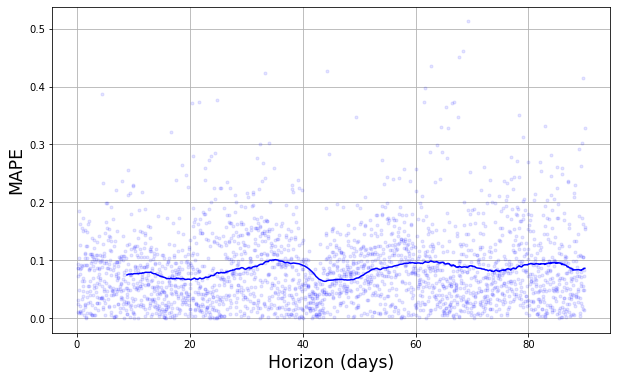

In [41]:
fig = plot_cross_validation_metric(result2_cv_adj[::2], metric='mape')
plt.xlabel('Horizon (days)', fontsize='xx-large')
plt.ylabel('MAPE', fontsize='xx-large')
fig.savefig('prophet2_horizon_mape.png')

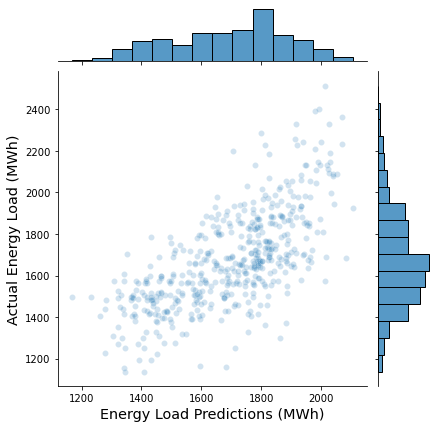

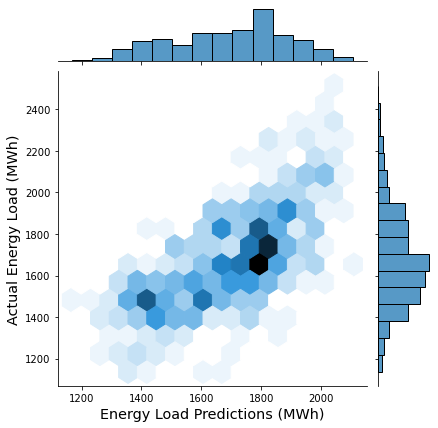

In [42]:
step = 10
grid = sns.jointplot(result2_cv_adj.yhat[::step], result2_cv_adj.y[::step], alpha=0.2)
grid.set_axis_labels('Energy Load Predictions (MWh)', 'Actual Energy Load (MWh)', fontsize='x-large')
grid.savefig('joint_scatter2.png')

grid = sns.jointplot(result2_cv_adj.yhat[::step], result2_cv_adj.y[::step], kind='hex')
grid.set_axis_labels('Energy Load Predictions (MWh)', 'Actual Energy Load (MWh)', fontsize='x-large')
grid.savefig('joint_hex2.png')

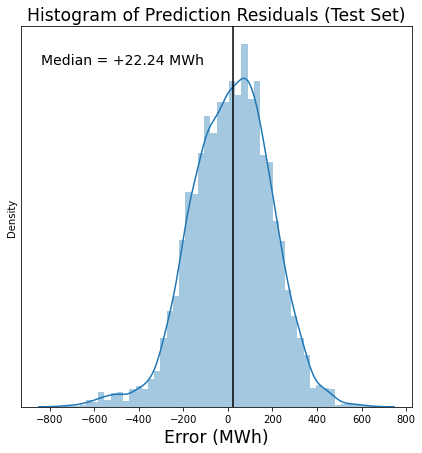

In [43]:
errs2 = result2_cv_adj.yhat - result2_cv_adj.y      # Units are now MWh, not standardized
fig = plot_residuals(errs2)
fig.savefig('residuals2_hist.png')
fig.show()

In [44]:
print('The median error was {0:.2%} of the mean energy demand.'.format(errs2.median() / result2_cv_adj.y.mean()))

The median error was 1.32% of the mean energy demand.


### Third Model

In [45]:
def is_winter(ds):
    '''
    This function converts each timestamp into a binary value based on whether
    or not it falls in the months of December, January, or Fabruary
    '''
    date = pd.to_datetime(ds)
    if ((ds.month % 12 + 3) // 3) == 1: return 1
    else: return 0

def is_summer(ds):
    '''
    This function converts each timestamp into a binary value based on whether
    or not it falls in the months of June, July, or August
    '''
    date = pd.to_datetime(ds)
    if ((ds.month % 12 + 3) // 3) == 3: return 1
    else: return 0

In [46]:
# Create columns for the season the observation is in
data_seasons = data.copy()
data_seasons["is_winter"] = data_seasons.ds.apply(is_winter)
data_seasons["is_summer"] = data_seasons.ds.apply(is_summer)
data_seasons['is_spring_fall'] = ~(data_seasons.is_winter | data_seasons.is_summer) + 2
data_seasons.to_csv('data_seasons.csv')

# Standardize the seasoned data
colx = ['y', 'weather_pc', 'weather_pc2', 'visibility']
colkeep = ['ds', 'is_winter', 'is_summer', 'is_spring_fall']

data_seasons_st = (data_seasons[colx] - data_seasons[colx].mean()) / data_seasons[colx].std()
data_seasons_st[colkeep] = data_seasons[colkeep]

data_seasons_st['cap'] = data_seasons_st['y'].max()*1.2
data_seasons_st['floor'] = 0

data_seasons_st.to_csv('data_seasons_st.csv')

In [47]:
# Create base instance of Prophet
prophet3 = Prophet(seasonality_prior_scale=35,
                   daily_seasonality=False,
                   weekly_seasonality=False,
                   growth="logistic",
                   seasonality_mode='additive')

# Add holidays
prophet3.add_country_holidays(country_name="FR")

# Add seasonalities
prophet3.add_seasonality(name='daily_winter', period=1, fourier_order=10, condition_name='is_winter')
prophet3.add_seasonality(name='daily_summer', period=1, fourier_order=10, condition_name='is_summer')
prophet3.add_seasonality(name='daily_spring_fall', period=1, fourier_order=10, condition_name='is_spring_fall')
prophet3.add_seasonality(name='weekly', period=7, fourier_order=10)
prophet3.add_seasonality(name='quarterly', period=365/4, fourier_order=10)

# Add weather regressor
prophet3.add_regressor('weather_pc')
prophet3.add_regressor('weather_pc2')

prophet3.fit(data_seasons_st)     # will take 13 minutes to run

prophet3.stan_backend.logger = None
with open("prophet3.pickle", "wb") as f:
    pickle.dump(prophet3, f)

In [48]:
# Create dataframe containing each hour in the prediction period
pred_period3 = prophet3.make_future_dataframe(periods=n_hours, freq="H")

pred_period3['cap'] = data_seasons_st['y'].max()*1.2
pred_period3['floor'] = 0

# Create empty columns for the `weather_pc` and `visibility` data
pred_period3['weather_pc'] = 0.
pred_period3['weather_pc2'] = 0.

# Fill in the historical data for the `weather_pc` and `visibility` columns
pred_period3['weather_pc'][:-n_hours] = data_st.weather_pc
pred_period3['weather_pc2'][:-n_hours] = data_st.visibility

# Forecast the weather and visibility for the prediction period
pred_weather_regressors = pred_period3.iloc[-n_hours:].ds.apply(fill_regressors)

# Add the forecasted data to the prediction period dataframe
pred_period3['weather_pc'][-n_hours:] = pred_weather_regressors.weather_pc
pred_period3['weather_pc2'][-n_hours:] = pred_weather_regressors.visibility

pred_period3["is_winter"] = pred_period3.ds.apply(is_winter)
pred_period3["is_summer"] = pred_period3.ds.apply(is_summer)
pred_period3['is_spring_fall'] = ~(pred_period3.is_winter | pred_period3.is_summer) + 2
pred_period3.to_csv('pred_period3.csv')

In [49]:
# Forecast the energy load over the prediction perdiod dataframe
preds3 = prophet3.predict(pred_period3.dropna(inplace=True))

In [50]:
n_months = 24
n_days = n_months * 30
n_hours = (n_days * 24) // 3
print("We want to forecast:\n - {0} months, which is\n - {1} days, which is\n - {2} 3hours".format(n_months, n_days, n_hours))

We want to forecast:
 - 24 months, which is
 - 720 days, which is
 - 5760 3hours


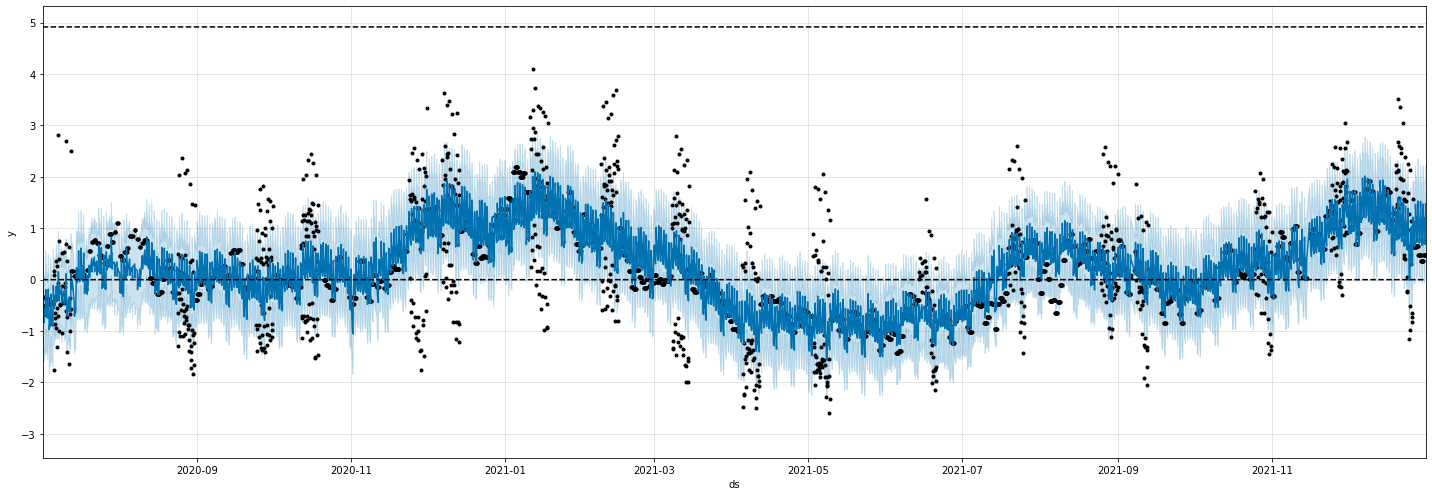

In [51]:
backtrack = (0.5 * 12 * 30 * 24) // 3
backtrack = int(backtrack)

fig = prophet1.plot(preds3[-backtrack - n_hours:], figsize=(20, 7))
plt.plot(data_st.ds[-backtrack:], data_st.y[-backtrack:], '--')
plt.xlim(data_st.ds.values[-backtrack], preds3.ds.values[-1] + np.timedelta64())
fig.show()

fig.savefig('prophet3_predictions.png')

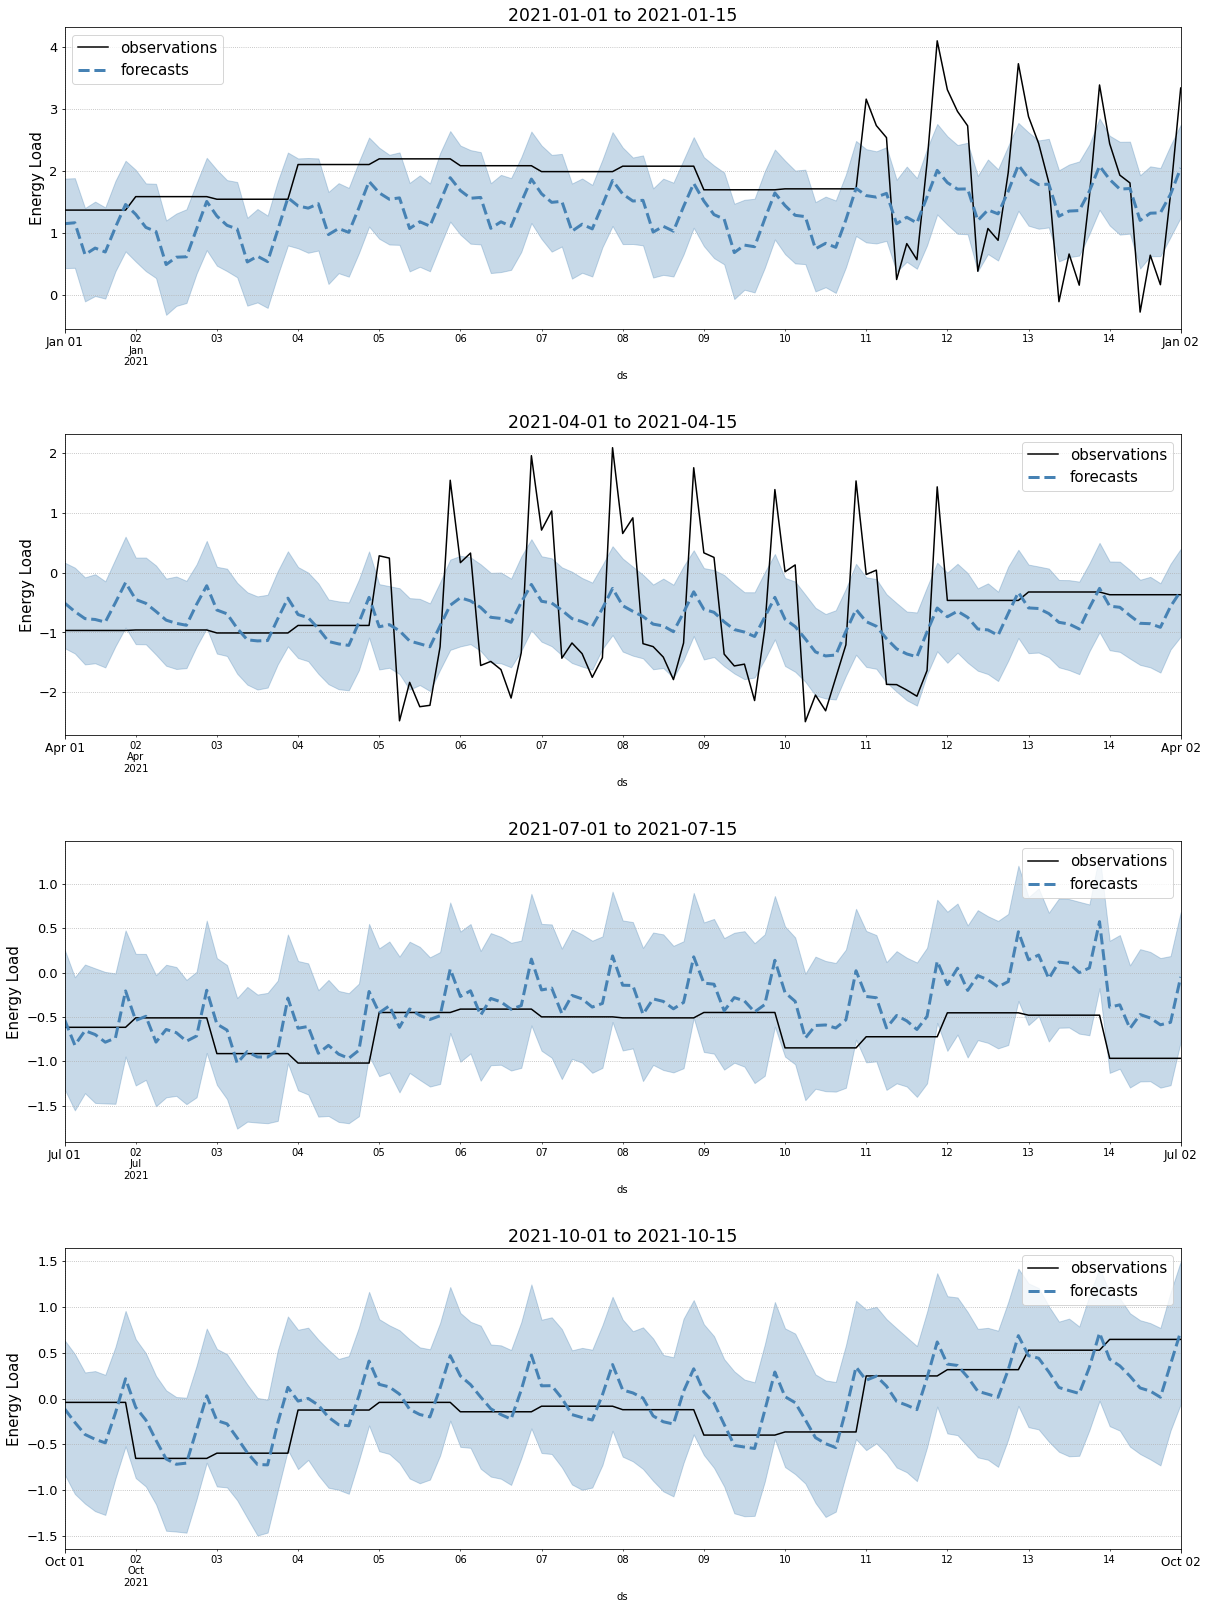

In [52]:
fig = plot_seasons(preds3, '2021')
fig.savefig('season_preds3.png')

### Examine the seasonality components of the model

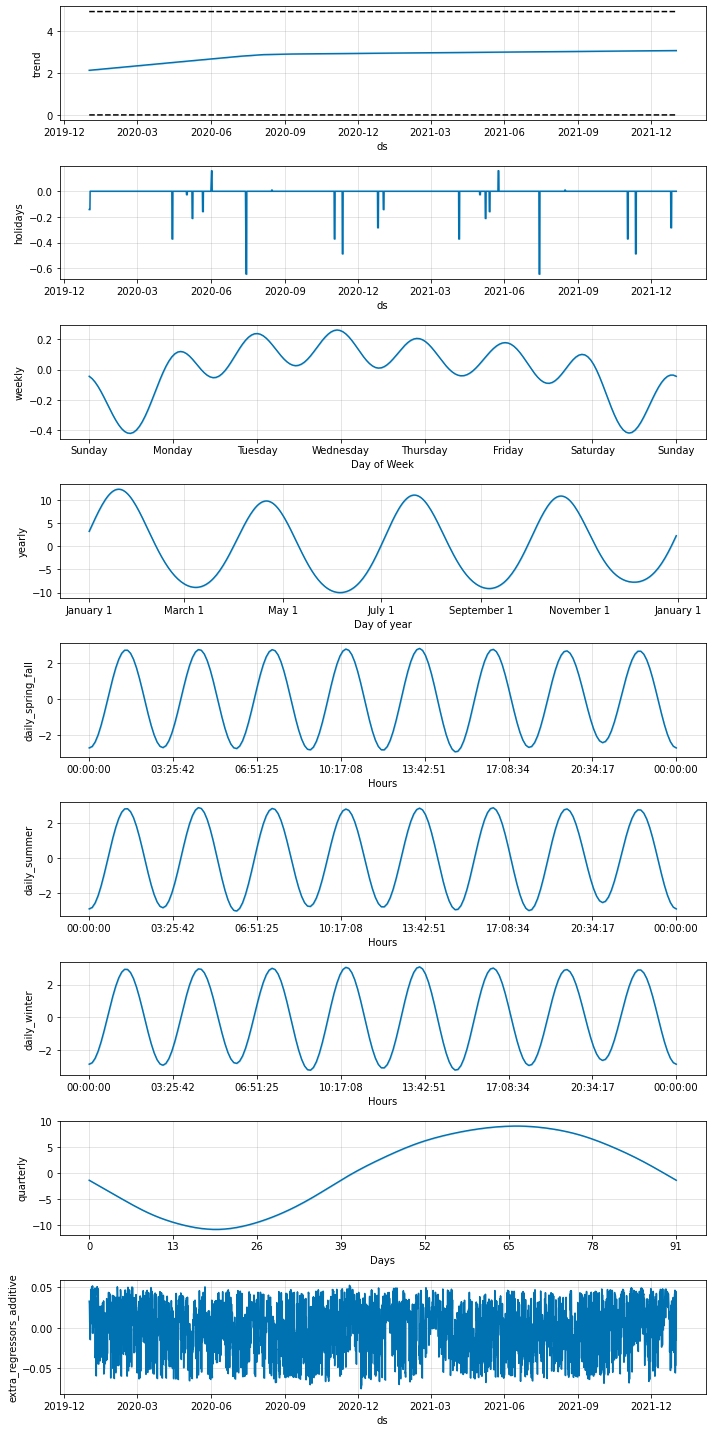

In [53]:
fig = prophet3.plot_components(preds3, figsize=(10, 20))
fig.savefig('prophet3_components.png')
fig.show()

### Model Validation

In [54]:
result3_cv = diagnostics.cross_validation(prophet3, horizon="90 days")
result3_cv.to_csv('result3_cv.csv')

# Unstandardize the results
result3_cv_adj = result3_cv.copy()
result3_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] *= data.y.std()
result3_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] += data.y.mean()
result3_cv_adj.to_csv('result3_cv_adj.csv')

INFO:prophet:Making 7 forecasts with cutoffs between 2021-01-05 21:00:00 and 2021-10-02 21:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

In [56]:
print("Mean average percent error: {:.2%}".format(mape(result3_cv_adj.yhat, result3_cv_adj.y)))

INFO:prophet:Making 7 forecasts with cutoffs between 2021-01-05 21:00:00 and 2021-10-02 21:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

Mean average percent error: 12.03%


In [57]:
result3_p = performance_metrics(result3_cv_adj)
result3_p.to_csv('result3_p.csv')

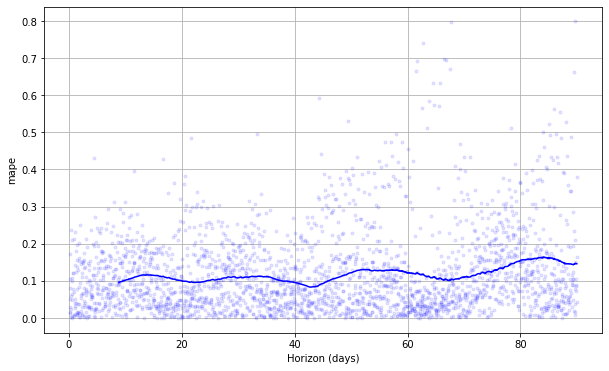

In [58]:
fig = plot_cross_validation_metric(result3_cv_adj[::2], metric='mape')
fig.savefig('prophet3_horizon_mape.png')

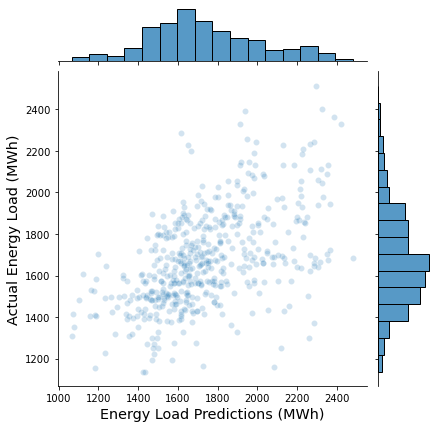

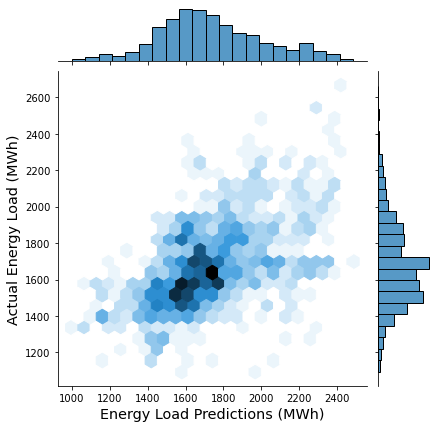

In [59]:
step = 10
grid = sns.jointplot(result3_cv_adj.yhat[::step], result3_cv_adj.y[::step], alpha=0.2)
grid.set_axis_labels('Energy Load Predictions (MWh)', 'Actual Energy Load (MWh)', fontsize='x-large')
grid.savefig('joint_scatter3.png')

step = 5
grid = sns.jointplot(result3_cv_adj.yhat[::step], result3_cv_adj.y[::step], kind='hex')
grid.set_axis_labels('Energy Load Predictions (MWh)', 'Actual Energy Load (MWh)', fontsize='x-large')
grid.savefig('joint_hex3.png')

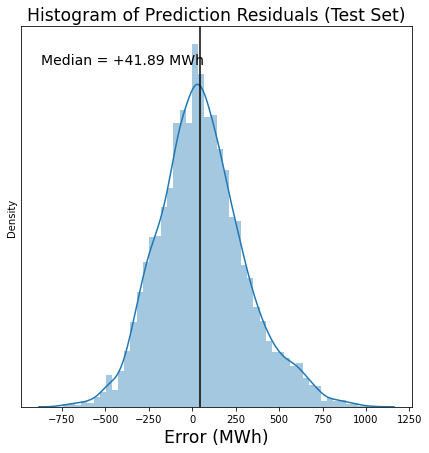

In [60]:
errs3 = result3_cv_adj.yhat - result3_cv_adj.y      # Units are now MWh, not standardized
fig = plot_residuals(errs3)
fig.savefig('residuals3_hist.png')
fig.show()

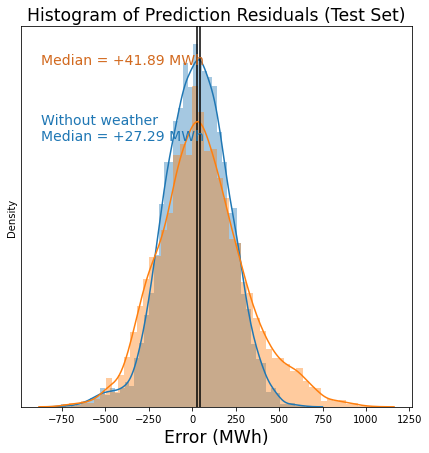

In [61]:
fig, ax = plt.subplots(figsize=(7, 7))
fig = plot_residuals(errs1, fig=fig, ax=ax, display=False)
fig = plot_residuals(errs3, fig=fig, ax=ax, display=False)

ax.text(0.05, 0.9, "Median = {:+4.2f} MWh".
        format((errs3).median()),
        fontsize=14, transform=ax.transAxes, color='chocolate')

ax.text(0.05, 0.7, "Without weather\nMedian = {:+4.2f} MWh".
        format((errs1).median()),
        fontsize=14, transform=ax.transAxes, color='C0')

fig.savefig('residuals13_hist.png')
fig.show()

In [62]:
result3_day = result3_cv_adj.groupby(by=[result3_cv_adj.ds.dt.day,
                                         result3_cv_adj.ds.dt.month,
                                         result3_cv_adj.ds.dt.year]).sum()
result3_month = result3_cv_adj.groupby(by=[result3_cv_adj.ds.dt.month,
                                           result3_cv_adj.ds.dt.year]).sum()
result3_ag = result3_cv_adj.groupby('cutoff').sum()

print("Hourly mean average percent error: {:.2%}".format(mape(result3_cv_adj.yhat, result3_cv_adj.y)))
print("Daily mean average percent error: {:.2%}".format(mape(result3_day.yhat, result3_day.y)))
print("Monthly mean average percent error: {:.2%}".format(mape(result3_month.yhat, result3_month.y)))
print("3-month mean average percent error: {:.2%}".format(mape(result3_ag.yhat, result3_ag.y)))

Hourly mean average percent error: 12.03%
Daily mean average percent error: 9.94%
Monthly mean average percent error: 7.01%
3-month mean average percent error: 6.09%


In [63]:
print('The median error was {0:.2%} of the mean energy demand.'.format(errs3.median() / result3_cv_adj.y.mean()))

The median error was 2.49% of the mean energy demand.
